In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, make_scorer
from sklearn.preprocessing import MaxAbsScaler

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

from imblearn.over_sampling import *
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
# Define file path to dataset
file_path = 'tv_publisher.csv'

# Define dataframe
df_tv_publisher = pd.read_csv(file_path)

display(df_tv_publisher.head(10))

,device_id,timestamp_utc,cost_milli_cent
0,ctv81YlbBXho,2024-04-23 21:09:46,2325.51
1,ctvWr7bOO5Je,2024-04-19 18:31:30,2325.51
2,ctvktBqDUgcV,2024-05-07 23:32:37,2325.51
3,ctv4bFFpBJms,2024-06-28 00:10:10,2325.51
4,ctvFZB9pUMZ7,2024-05-24 03:45:45,2325.51
5,ctvFZB9pUMZ7,2024-06-01 15:01:27,2325.51
6,ctvFZB9pUMZ7,2024-06-01 15:43:41,2325.51
7,ctvmXq002HtT,2024-04-07 04:15:16,2325.51
8,ctvmXq002HtT,2024-06-29 04:31:54,2325.51
9,ctvZnkmr9EOU,2024-03-08 11:36:12,2325.51


In [3]:
print(len(df_tv_publisher))

5827133


# Missing Values

In [4]:
print(df_tv_publisher.dtypes)

device_id           object
timestamp_utc       object
cost_milli_cent    float64
dtype: object


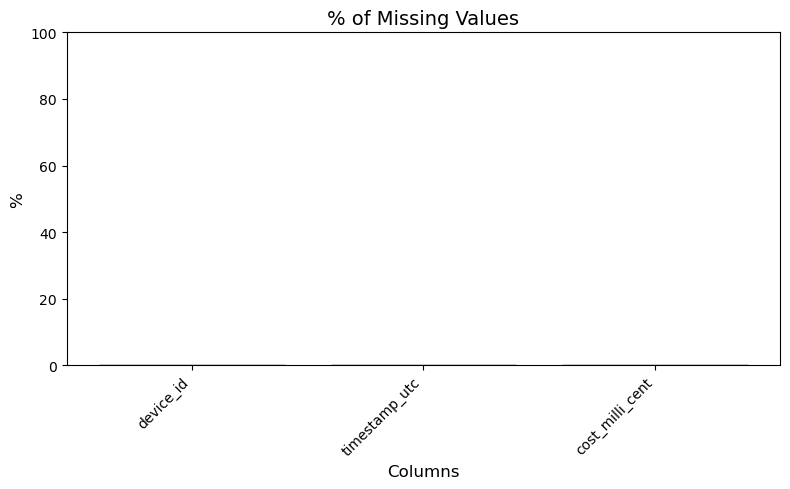

                 Missing Count  Missing Percentage (%)
device_id                    0                     0.0
timestamp_utc                0                     0.0
cost_milli_cent              0                     0.0


In [5]:
def count_missing_values_summary(df):
    missing_counts = df.isnull().sum()
    missing_percentage = (missing_counts / len(df)) * 100
    missing_columns = missing_counts[missing_counts > 0]
    missing_summary = pd.DataFrame({
        'Missing Count': missing_counts,
        'Missing Percentage (%)': missing_percentage}
    ).sort_values(by='Missing Count', ascending=False)
    
    # Create the histogram
    plt.figure(figsize=(8, 5))
    plt.ylim(0, 100)
    plt.bar(missing_summary.index, missing_summary['Missing Percentage (%)'], color='skyblue', edgecolor='black')
    plt.xlabel('Columns', fontsize=12)
    plt.ylabel('%', fontsize=12)
    plt.title('% of Missing Values', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return missing_summary

# Example usage
summary = count_missing_values_summary(df_tv_publisher)
print(summary)

### Analyse of 'timestamp_utc' column

#### Convert Object datatype to datetime

In [6]:
# Convert 'timestamp_utc' to datetime
df_tv_publisher['timestamp_utc'] = pd.to_datetime(df_tv_publisher['timestamp_utc'])

# Verify the new data type
print(df_tv_publisher['timestamp_utc'].dtypes)

datetime64[ns]


In [7]:
df_tv_publisher['year'] = df_tv_publisher['timestamp_utc'].dt.year
df_tv_publisher['month'] = df_tv_publisher['timestamp_utc'].dt.month
df_tv_publisher['day'] = df_tv_publisher['timestamp_utc'].dt.day
df_tv_publisher['day_of_week'] = df_tv_publisher['timestamp_utc'].dt.dayofweek
df_tv_publisher['quarter'] = df_tv_publisher['timestamp_utc'].dt.quarter


In [8]:
# Group by day and count unique device_ids
timestamp_counts = df_tv_publisher.groupby(df_tv_publisher['timestamp_utc'].dt.date)['device_id'].count()

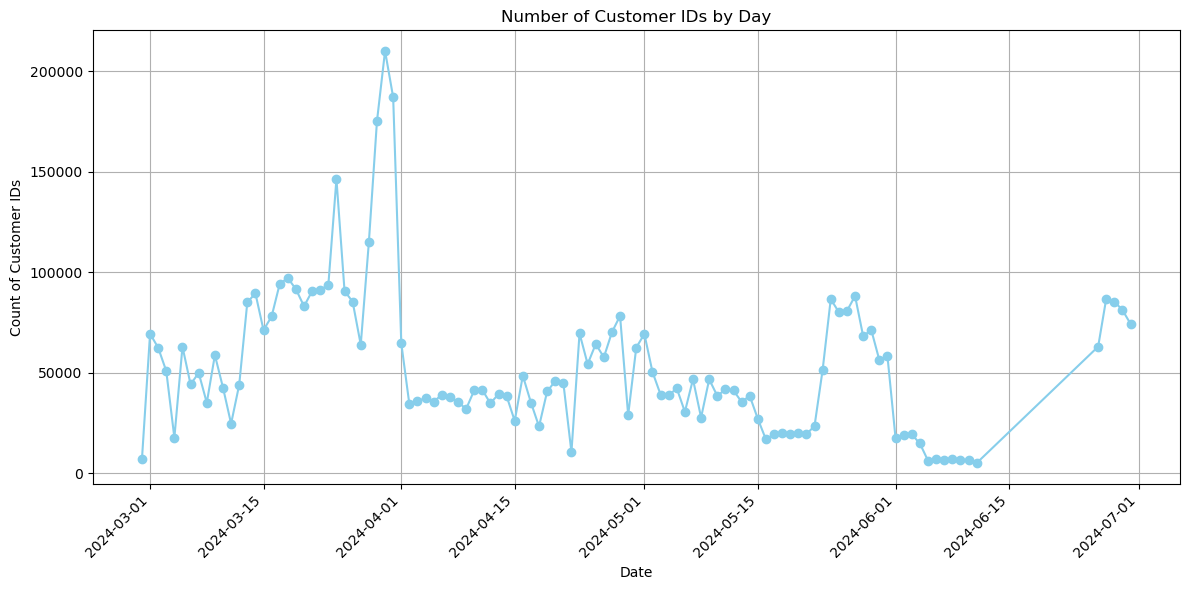

In [9]:
# Plot customer counts by day
plt.figure(figsize=(12, 6))
timestamp_counts.plot(kind='line', marker='o', color='skyblue')
plt.title('Number of Customer IDs by Day')
plt.xlabel('Date')
plt.ylabel('Count of Customer IDs')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
# Top 10 days with the most customer IDs
top_days = timestamp_counts.sort_values(ascending=False).head(10)
print("Top 10 days with the most customer IDs:")
print(top_days)

Top 10 days with the most customer IDs:
timestamp_utc
2024-03-30    210160
2024-03-31    187121
2024-03-29    175181
2024-03-24    146493
2024-03-28    114924
2024-03-18     97189
2024-03-17     94281
2024-03-23     93688
2024-03-19     91664
2024-03-22     91395
Name: device_id, dtype: int64


In [11]:
# Ensure 'timestamp_utc' is a datetime object
df_tv_publisher['timestamp_utc'] = pd.to_datetime(df_tv_publisher['timestamp_utc'])

# Generate a complete range of dates
complete_date_range = pd.date_range(
    start=df_tv_publisher['timestamp_utc'].min(),
    end=df_tv_publisher['timestamp_utc'].max(),
    freq='D'  # Daily frequency
)
# Extract unique dates from the dataset
available_dates = df_tv_publisher['timestamp_utc'].dt.date.unique()

# Identify missing dates
missing_dates = set(complete_date_range.date) - set(available_dates)

In [12]:
# Total number of dates
total_dates = len(complete_date_range)

# Number of missing dates
num_missing_dates = len(missing_dates)

# Percentage of missing dates
percent_missing = (num_missing_dates / total_dates) * 100

print(f"Total dates: {total_dates}")
print(f"Missing dates: {num_missing_dates}")
print(f"Percentage of missing dates: {percent_missing:.2f}%")


Total dates: 123
Missing dates: 14
Percentage of missing dates: 11.38%


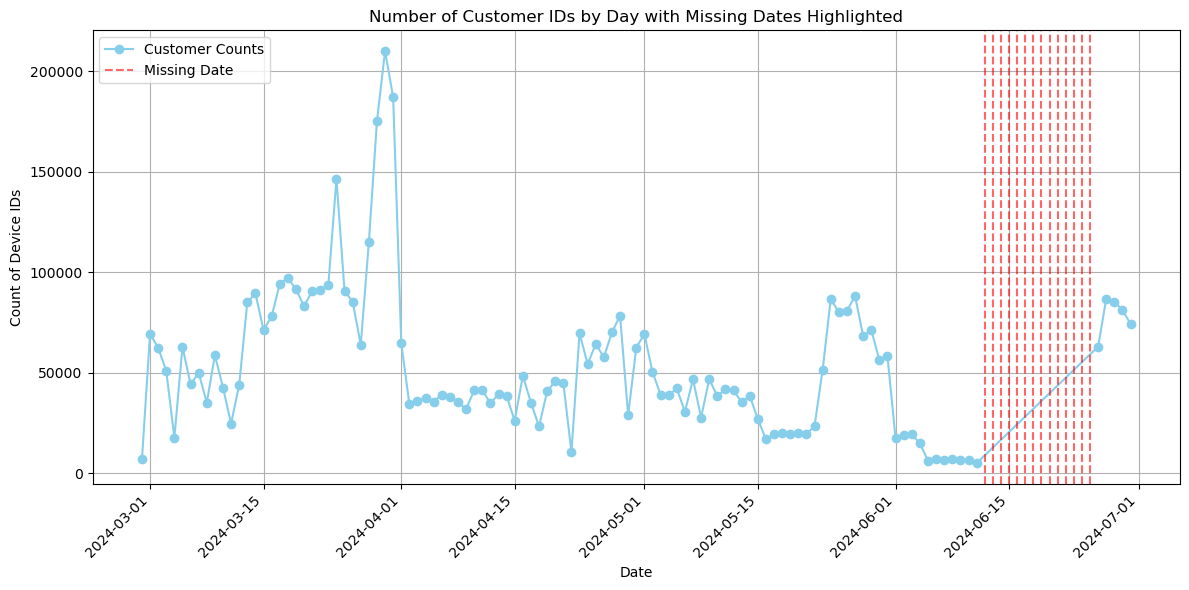

In [13]:
# Ensure 'timestamp_utc' is a datetime object
df_tv_publisher['timestamp_utc'] = pd.to_datetime(df_tv_publisher['timestamp_utc'])

# Extract unique dates and generate the complete date range
available_dates = df_tv_publisher['timestamp_utc'].dt.date.unique()
complete_date_range = pd.date_range(start=df_tv_publisher['timestamp_utc'].min(), end=df_tv_publisher['timestamp_utc'].max(), freq='D')

# Identify missing dates
missing_dates = sorted(set(complete_date_range.date) - set(available_dates))

# Aggregate data: Count customer IDs per day
timestamp_counts = df_tv_publisher.groupby(df_tv_publisher['timestamp_utc'].dt.date)['device_id'].count()

# Plot customer counts by day
plt.figure(figsize=(12, 6))
plt.plot(timestamp_counts.index, timestamp_counts.values, marker='o', color='skyblue', label='Customer Counts')

# Highlight missing dates
for missing_date in missing_dates:
    plt.axvline(missing_date, color='red', linestyle='--', alpha=0.6, label='Missing Date' if missing_date == missing_dates[0] else "")

# Add title and labels
plt.title('Number of Customer IDs by Day with Missing Dates Highlighted')
plt.xlabel('Date')
plt.ylabel('Count of Device IDs')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Analyse 'cost_milli_cent' column

In [14]:
# Aggregate costs by day (you can adjust to hourly or other timeframes)
costs_over_time = df_tv_publisher.groupby(df_tv_publisher['timestamp_utc'].dt.date)['cost_milli_cent'].sum()

# Convert millicents to cents for better readability
costs_over_time = costs_over_time / 1000

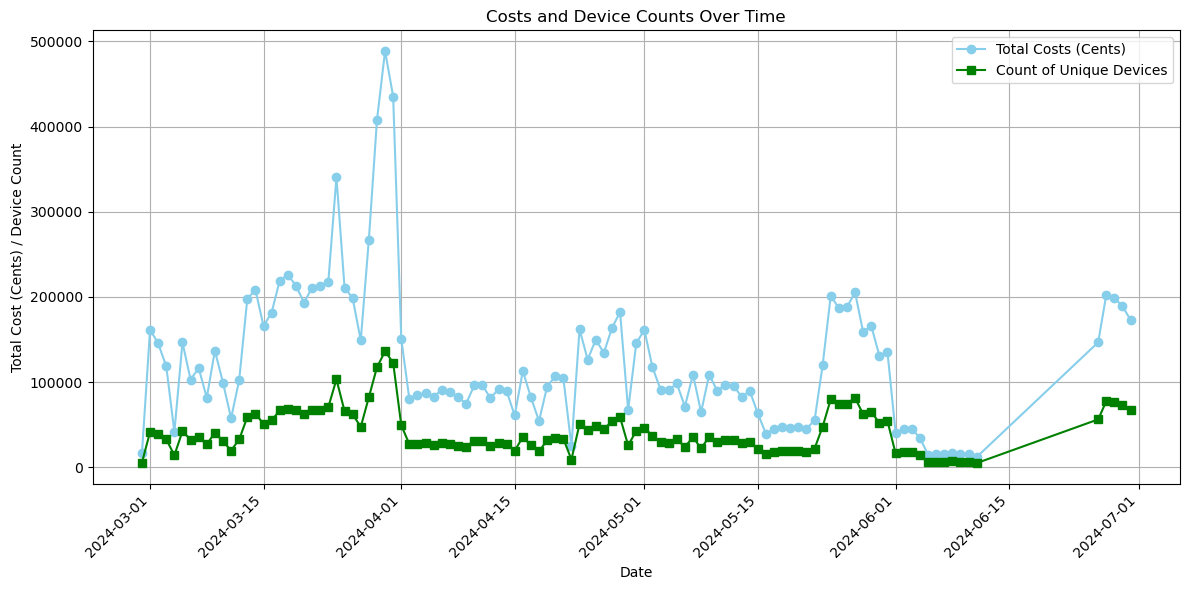

In [41]:
import matplotlib.pyplot as plt

# Aggregate data: Count of devices per day
device_counts_over_time = df_tv_publisher.groupby(df_tv_publisher['timestamp_utc'].dt.date)['device_id'].nunique()

# Aggregate costs over time
costs_over_time = df_tv_publisher.groupby(df_tv_publisher['timestamp_utc'].dt.date)['cost_milli_cent'].sum() / 1000  # Convert to cents

# Plot costs and device counts over time
plt.figure(figsize=(12, 6))

# Plot costs over time
plt.plot(costs_over_time.index, costs_over_time.values, marker='o', color='skyblue', label='Total Costs (Cents)')

# Plot device counts over time
plt.plot(device_counts_over_time.index, device_counts_over_time.values, marker='s', color='green', label='Count of Unique Devices')

# Add title and labels
plt.title('Costs and Device Counts Over Time')
plt.xlabel('Date')
plt.ylabel('Total Cost (Cents) / Device Count')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
device_costs = df_tv_publisher.groupby(['device_id', df_tv_publisher['timestamp_utc'].dt.date])['cost_milli_cent'].sum() / 1000
print(device_costs.head())

device_id     timestamp_utc
ctv000660oW2  2024-05-26       2.32551
              2024-05-27       2.32551
              2024-05-29       2.32551
              2024-06-27       2.32551
              2024-06-28       2.32551
Name: cost_milli_cent, dtype: float64


In [17]:
# Check for unique cost_milli_cent values per device_id
device_cost_variability = df_tv_publisher.groupby('device_id')['cost_milli_cent'].nunique()

# Identify devices with constant costs
constant_cost_devices = device_cost_variability[device_cost_variability == 1]

# Print summary
print(f"Devices with constant cost_milli_cent values: {len(constant_cost_devices)}")
print(f"Devices with varying cost_milli_cent values: {len(device_cost_variability) - len(constant_cost_devices)}")

Devices with constant cost_milli_cent values: 2065526
Devices with varying cost_milli_cent values: 13


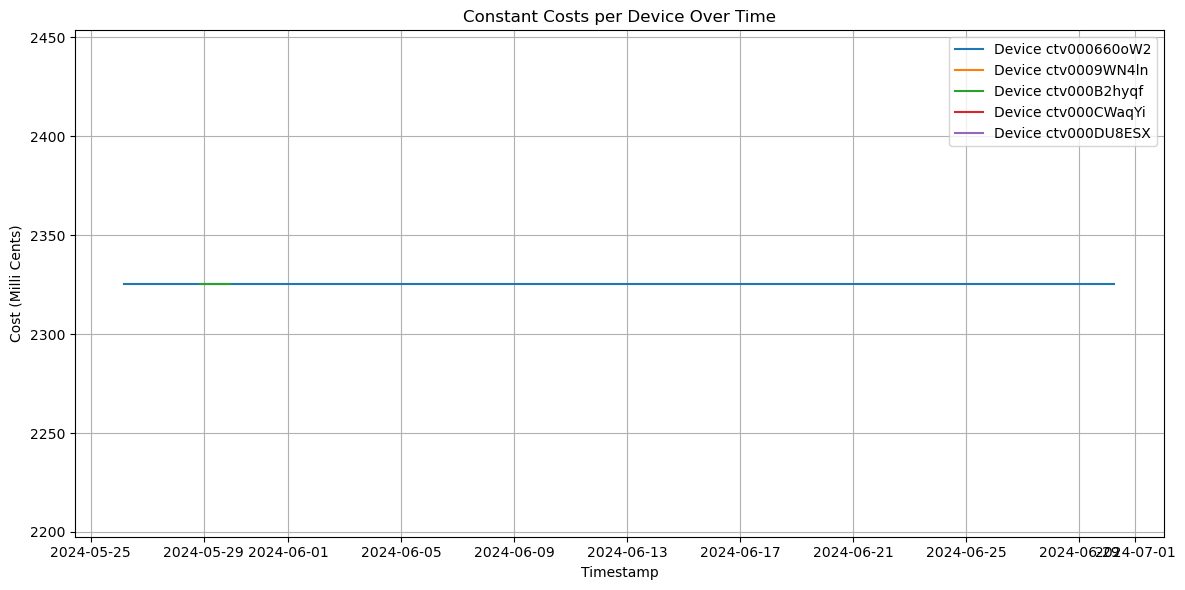

In [21]:
# Filter data for devices with constant costs
constant_devices = df_tv_publisher[df_tv_publisher['device_id'].isin(constant_cost_devices.index)]

# Plot cost_milli_cent for a sample of constant devices
plt.figure(figsize=(12, 6))

# Example with first 5 constant devices
for device_id in constant_cost_devices.index[:5]:
    device_data = constant_devices[constant_devices['device_id'] == device_id]
    plt.plot(device_data['timestamp_utc'], device_data['cost_milli_cent'], label=f'Device {device_id}')

plt.title('Constant Costs per Device Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Cost (Milli Cents)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

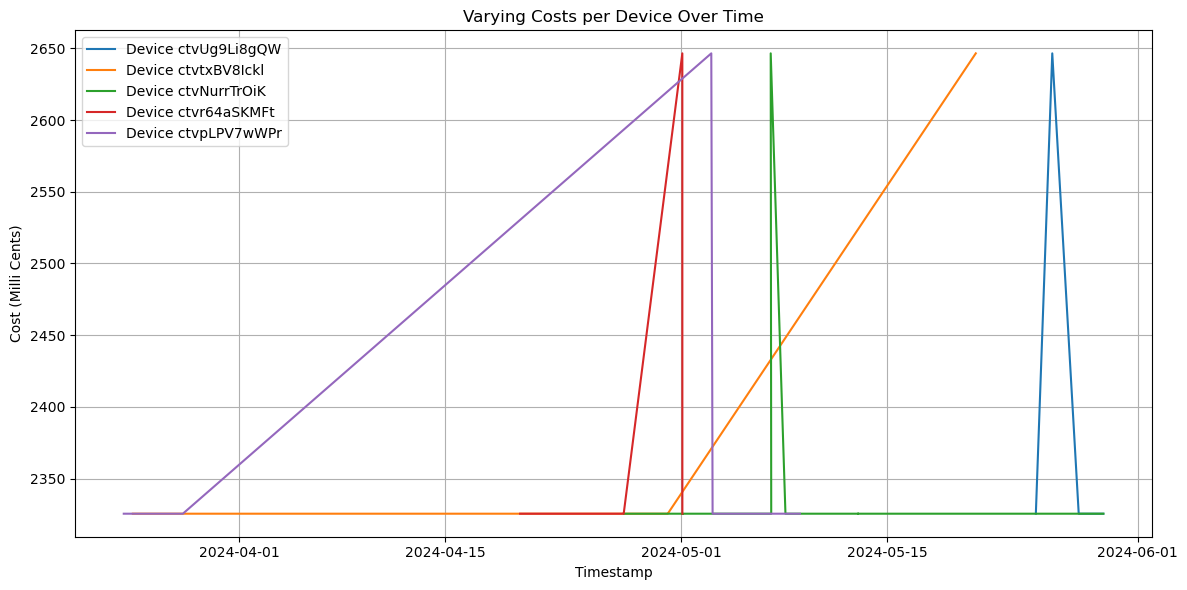

In [20]:
# Filter data for devices with varying costs
varying_devices = df_tv_publisher[~df_tv_publisher['device_id'].isin(constant_cost_devices.index)]

# Plot cost_milli_cent for a sample of varying devices
plt.figure(figsize=(12, 6))

# Example with first 5 varying devices
for device_id in varying_devices['device_id'].unique()[:5]:
    device_data = varying_devices[varying_devices['device_id'] == device_id]
    plt.plot(device_data['timestamp_utc'], device_data['cost_milli_cent'], label=f'Device {device_id}')

plt.title('Varying Costs per Device Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Cost (Milli Cents)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
# Count unique values in the 'cost_milli_cent' column
unique_cost_values = df_tv_publisher['cost_milli_cent'].nunique()

# Print the result
print(f"Number of unique values in 'cost_milli_cent': {unique_cost_values}")

Number of unique values in 'cost_milli_cent': 2


In [23]:
# List all unique cost values
unique_cost_list = df_tv_publisher['cost_milli_cent'].unique()
print("Unique values in 'cost_milli_cent':")
print(unique_cost_list)

Unique values in 'cost_milli_cent':
[2325.51 2646.51]


Percentage of each unique cost_milli_cent value:
cost_milli_cent
2325.51    99.99976
2646.51     0.00024
Name: proportion, dtype: float64


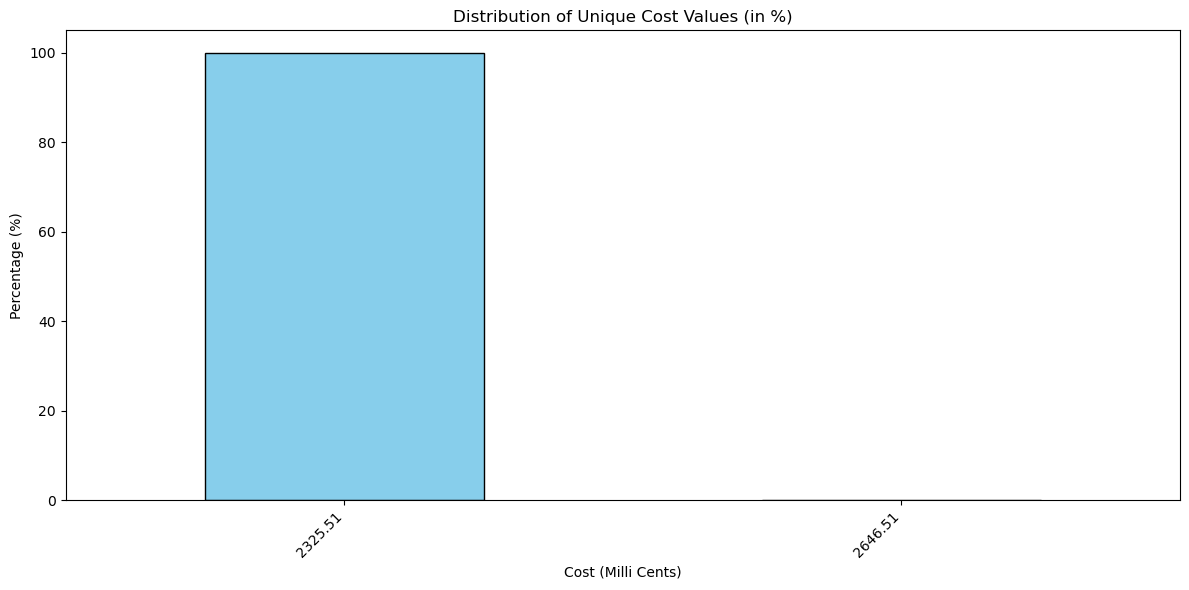

In [27]:
# Count occurrences of each unique cost and normalize to percentages
cost_counts = df_tv_publisher['cost_milli_cent'].value_counts(normalize=True) * 100

# Print the percentage values
print("Percentage of each unique cost_milli_cent value:")
print(cost_counts)

# Plot the distribution of unique costs as percentages
plt.figure(figsize=(12, 6))
cost_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Unique Cost Values (in %)')
plt.xlabel('Cost (Milli Cents)')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [31]:
# Filter rows where 'cost_milli_cent' equals 2646.51
specific_value_data = df_tv_publisher[df_tv_publisher['cost_milli_cent'] == 2646.51]

# Verify the data
print(f"Rows with 'cost_milli_cent' = 2646.51:")
display(specific_value_data.head(10))
print(df_tv_publisher.shape)

Rows with 'cost_milli_cent' = 2646.51:


,device_id,timestamp_utc,cost_milli_cent,year,month,day,day_of_week,quarter
504682,ctvUg9Li8gQW,2024-05-26 04:55:23,2646.51,2024,5,26,6,2
1019351,ctvtxBV8Ickl,2024-05-21 00:16:02,2646.51,2024,5,21,1,2
1576284,ctvNurrTrOiK,2024-05-07 02:02:24,2646.51,2024,5,7,1,2
1639993,ctvr64aSKMFt,2024-05-01 02:00:08,2646.51,2024,5,1,2,2
2111874,ctvpLPV7wWPr,2024-05-03 01:12:05,2646.51,2024,5,3,4,2
2173979,ctvxHweuEJ8q,2024-04-14 06:11:10,2646.51,2024,4,14,6,2
2996135,ctv74ddnP0fT,2024-05-21 02:05:54,2646.51,2024,5,21,1,2
3225536,ctvVfklJR8C3,2024-05-12 23:56:33,2646.51,2024,5,12,6,2
3385362,ctvkcjbybfsU,2024-05-03 03:48:26,2646.51,2024,5,3,4,2
4443446,ctvNoPJkq0Kg,2024-04-17 21:26:27,2646.51,2024,4,17,2,2


(5827133, 8)


In [37]:
# Add a day column
specific_value_data['day'] = specific_value_data['timestamp_utc'].dt.date

# Count occurrences by day
day_counts = specific_value_data['day'].value_counts()

print("\nOccurrences by Day:")
print(day_counts)


Occurrences by Day:
day
2024-05-21    3
2024-05-03    2
2024-05-26    1
2024-05-07    1
2024-05-01    1
2024-04-14    1
2024-05-12    1
2024-04-17    1
2024-05-20    1
2024-05-05    1
2024-05-17    1
Name: count, dtype: int64


C:\Users\lenna\AppData\Local\Temp\ipykernel_38372\3765539684.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  specific_value_data['day'] = specific_value_data['timestamp_utc'].dt.date


In [38]:
# Add a month column
specific_value_data['month'] = specific_value_data['timestamp_utc'].dt.month

# Count occurrences by month
month_counts = specific_value_data['month'].value_counts()

print("\nOccurrences by Month:")
print(month_counts)


Occurrences by Month:
month
5    12
4     2
Name: count, dtype: int64


C:\Users\lenna\AppData\Local\Temp\ipykernel_38372\197945212.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  specific_value_data['month'] = specific_value_data['timestamp_utc'].dt.month


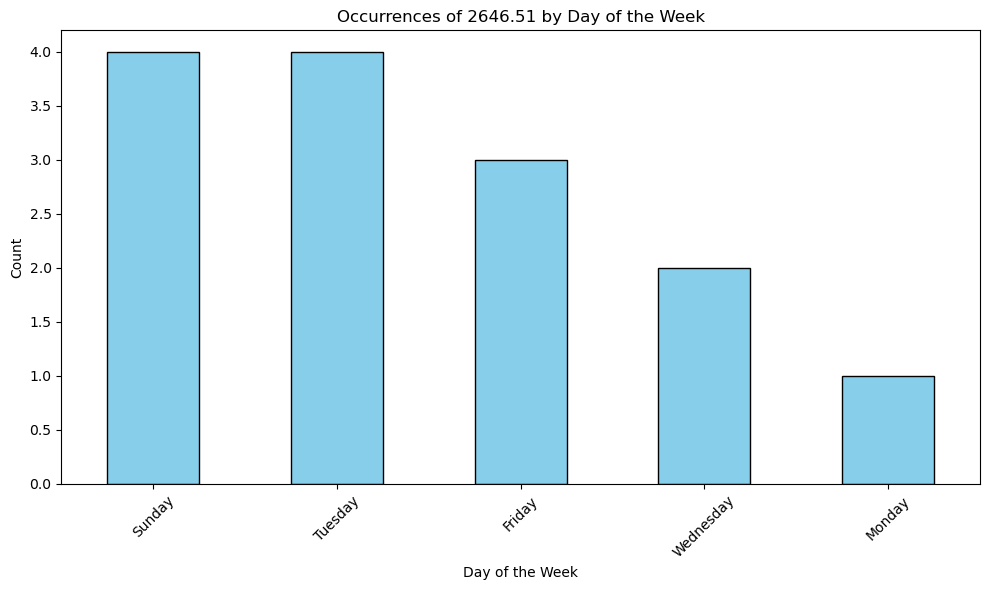

In [ ]:
# Plot occurrences by day of the week
plt.figure(figsize=(10, 6))
day_of_week_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Occurrences of 2646.51 by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [40]:
df_tv_publisher_cleaned = df_tv_publisher
display(df_tv_publisher.head(10))

,device_id,timestamp_utc,cost_milli_cent,year,month,day,day_of_week,quarter
0,ctv81YlbBXho,2024-04-23 21:09:46,2325.51,2024,4,23,1,2
1,ctvWr7bOO5Je,2024-04-19 18:31:30,2325.51,2024,4,19,4,2
2,ctvktBqDUgcV,2024-05-07 23:32:37,2325.51,2024,5,7,1,2
3,ctv4bFFpBJms,2024-06-28 00:10:10,2325.51,2024,6,28,4,2
4,ctvFZB9pUMZ7,2024-05-24 03:45:45,2325.51,2024,5,24,4,2
5,ctvFZB9pUMZ7,2024-06-01 15:01:27,2325.51,2024,6,1,5,2
6,ctvFZB9pUMZ7,2024-06-01 15:43:41,2325.51,2024,6,1,5,2
7,ctvmXq002HtT,2024-04-07 04:15:16,2325.51,2024,4,7,6,2
8,ctvmXq002HtT,2024-06-29 04:31:54,2325.51,2024,6,29,5,2
9,ctvZnkmr9EOU,2024-03-08 11:36:12,2325.51,2024,3,8,4,1
